In [ ]:
# !pip install scikit-surprise

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   BillNo                             Itemname  Quantity            Date  \
0  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  1/12/2010 8:26   
1  536365    GLASS STAR FROSTED T-LIGHT HOLDER         6  1/12/2010 8:26   
2  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  1/12/2010 8:26   
3  536365       RED WOOLLY HOTTIE WHITE HEART.         6  1/12/2010 8:26   
4  536365         SET 7 BABUSHKA NESTING BOXES         2  1/12/2010 8:26   

   Price  CustomerID   cost  
0   3.39       17850  20.34  
1   4.25       17850  25.50  
2   2.55       17850  15.30  
3   3.39       17850  20.34  
4   7.65       17850  15.30  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      200000 non-null  int64  
 1   Itemname    200000 non-null  object 
 2   Quantity    200000 non-null  int64  
 3   Date        200000 non-null  object 
 

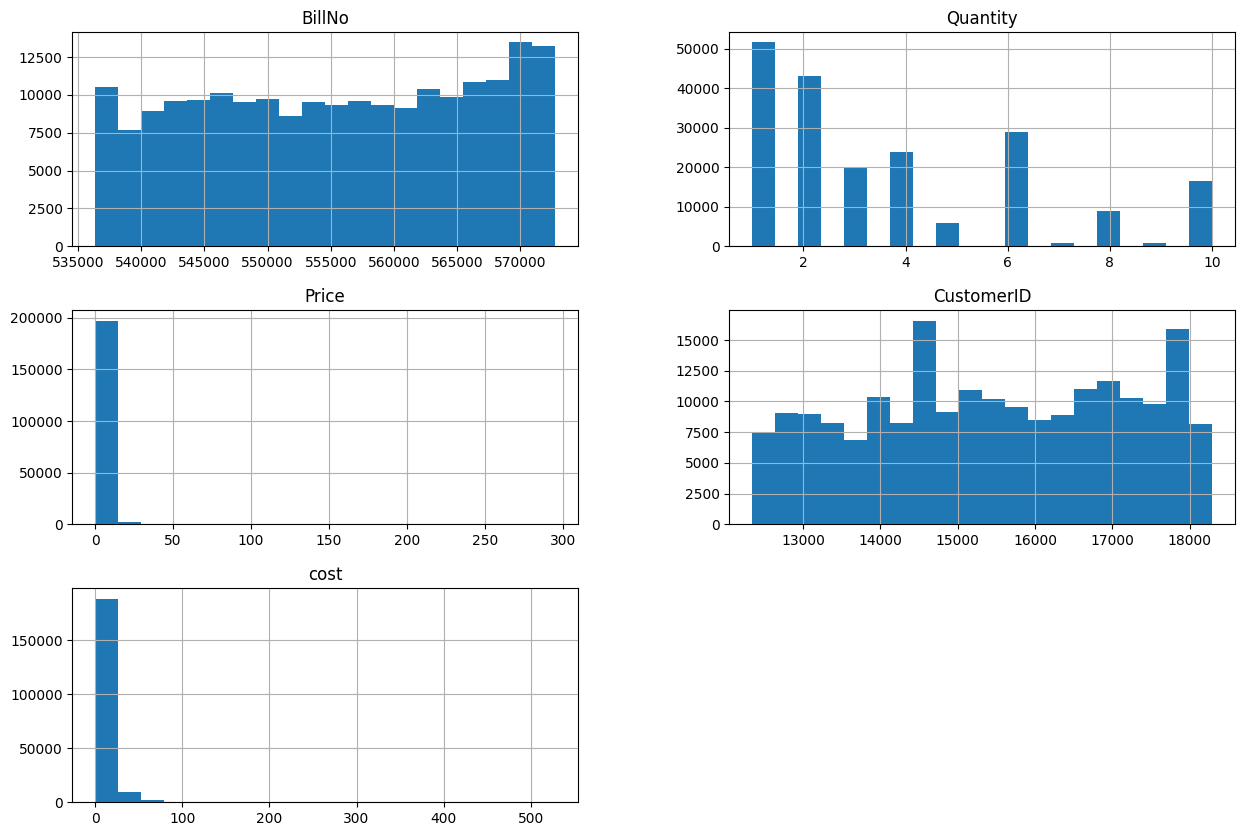

In [32]:
# First read the data for anaylize the base information and preprocess the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training dataset
train_data = pd.read_csv('basket_data_by_date_train_big.csv')

# Handle missing values and error values, check items' quantity and price is >0
train_data.dropna(inplace=True)
train_data = train_data[(train_data['Quantity'] > 0) & (train_data['Price'] > 0)]

print(train_data.head())

# Shows basic information including missing values
print(train_data.info())
print(train_data.describe())

# Plot each feature
train_data.hist(bins=20, figsize=(15, 10))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


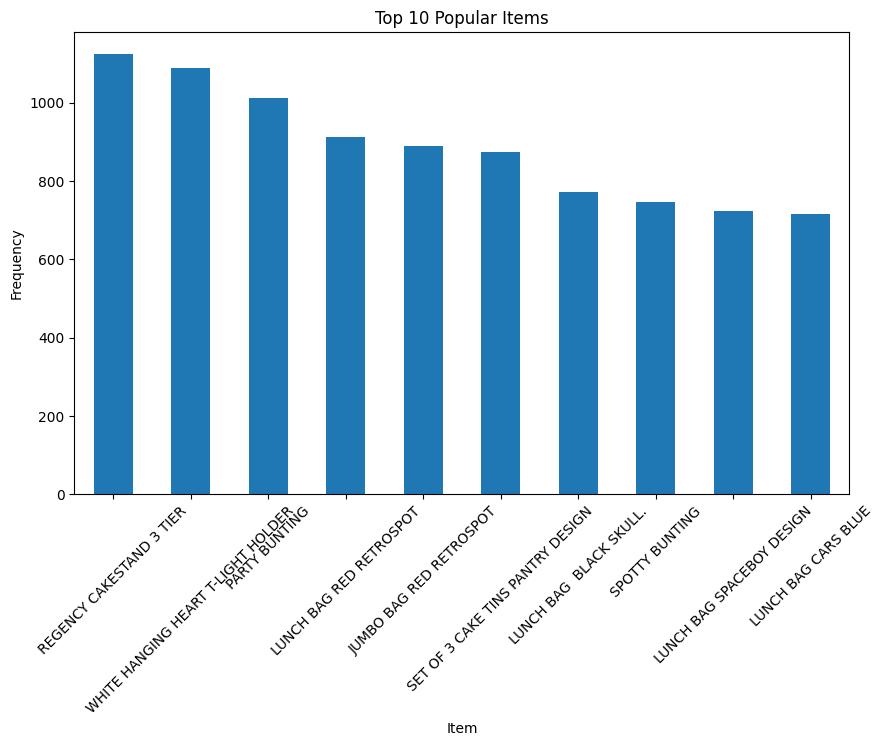

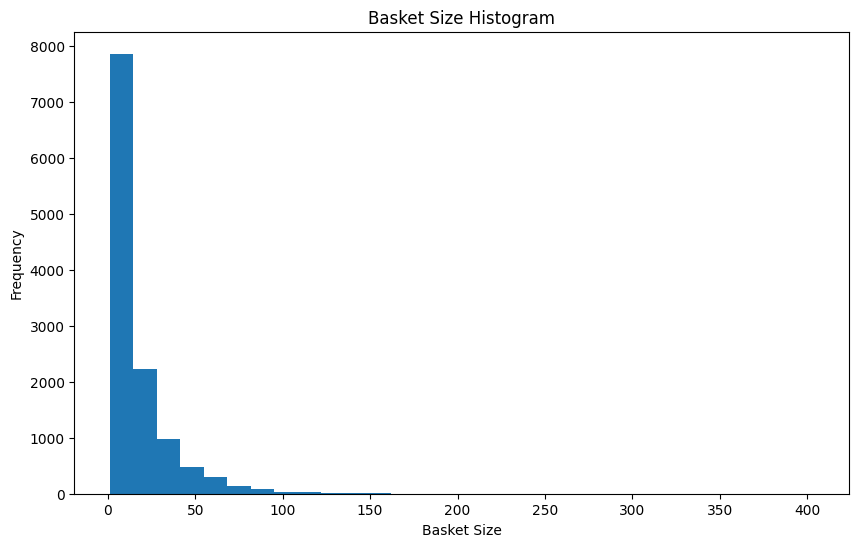

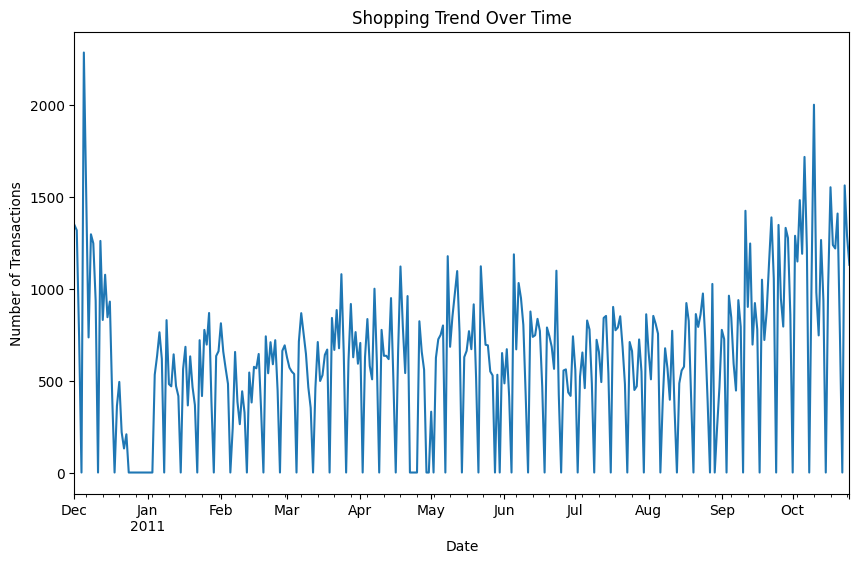

In [33]:
# Doing some anaylize of the dataset


train_data['Date'] = pd.to_datetime(train_data['Date'], format="%d/%m/%Y %H:%M")

#Bar chart top 10 items
popular_items = train_data['Itemname'].value_counts().head(10)
plt.figure(figsize=(10,6))
popular_items.plot(kind='bar')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.title('Top 10 Popular Items')
plt.xticks(rotation=45)
plt.show()


# basket size histogram
basket_size = train_data.groupby('BillNo').size()
plt.figure(figsize=(10,6))
plt.hist(basket_size, bins=30)
plt.xlabel('Basket Size')
plt.ylabel('Frequency')
plt.title('Basket Size Histogram')
plt.show()


# Shopping Time Anylize Line chart
train_data['Date'] = pd.to_datetime(train_data['Date'])
shopping_trend = train_data.set_index('Date').resample('D').size()
plt.figure(figsize=(10,6))
shopping_trend.plot()
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Shopping Trend Over Time')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


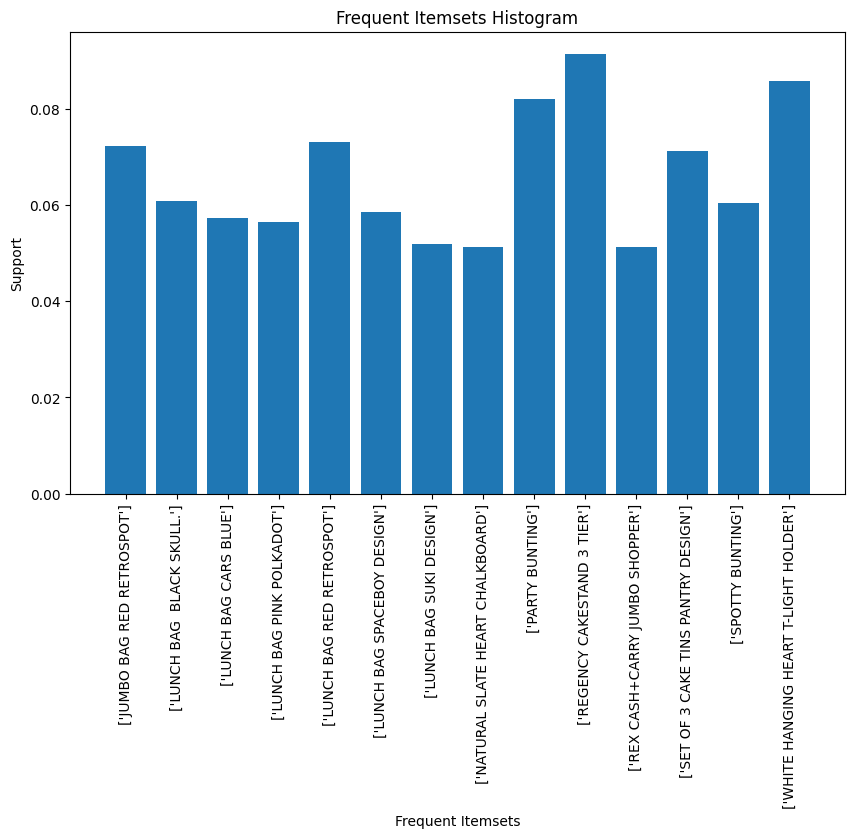

In [35]:
# Now doing some algorithm related anaylize
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


# Data preprocessing (converting into a format suitable for association rule mining)
basket = (train_data.groupby(['BillNo', 'Itemname'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('BillNo'))
# Convert the data set to Boolean type for association rule mining

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)


# Apriori algorithm finds frequent itemsets histogram
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: list(x))

plt.figure(figsize=(10,6))
plt.bar(range(len(frequent_itemsets)), frequent_itemsets['support'], tick_label=frequent_itemsets['itemsets'].astype(str))
plt.xlabel('Frequent Itemsets')
plt.ylabel('Support')
plt.title('Frequent Itemsets Histogram')
plt.xticks(rotation=90)
plt.show()


In [42]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Data Preprocessing
train_data = pd.read_csv('basket_data_by_date_train_big.csv')
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(train_data[['CustomerID', 'Itemname', 'Quantity']], reader)

# Model Training
trainset, testset = train_test_split(data, test_size=0.2)  # Split data into train and test sets
algo = SVD()  # Example collaborative filtering algorithm (SVD)
algo.fit(trainset)  # Train the model

# Model Evaluation
predictions = algo.test(testset)
accuracy = rmse(predictions)
print("RMSE:", accuracy)

# Generate Recommendations
test_data = pd.read_csv('basket_data_by_date_test_big.csv')  # Load test dataset
user_ids = test_data['CustomerID'].unique()  # Unique user IDs in the test dataset
recommendations = {}
for user_id in user_ids:
    items = train_data[train_data['CustomerID'] == user_id]['Itemname'].unique()
    not_purchased = test_data[test_data['CustomerID'] == user_id]['Itemname'].unique()
    unseen_items = [item for item in not_purchased if item not in items]
    predictions = [(item, algo.predict(user_id, item).est) for item in unseen_items]
    top_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]  # Select top 10 recommendations
    recommendations[user_id] = top_recommendations


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RMSE: 2.0746
RMSE: 2.074598499089966


In [43]:
# Performance Testing (evaluate recommendations on the test set)
total_users = test_data['CustomerID'].nunique()
correct_recommendations = 0
for user_id, top_recs in recommendations.items():
    actual_purchases = set(test_data[test_data['CustomerID'] == user_id]['Itemname'])
    recommended_items = set([rec[0] for rec in top_recs])
    correct_recommendations += len(actual_purchases.intersection(recommended_items))

precision = correct_recommendations / (total_users * 10)  # Assuming top 10 recommendations
print("Precision:", precision)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Precision: 0.7087095061072757


In [47]:
from surprise import KNNBasic

# Model Training
algo_knn = KNNBasic()  # Using KNNBasic algorithm
algo_knn.fit(trainset)  # Train the model

# Model Evaluation
predictions_knn = algo_knn.test(testset)
accuracy_knn = rmse(predictions_knn)
print("RMSE (KNNBasic):", accuracy_knn)

# Generate Recommendations
recommendations_knn = {}
for user_id in user_ids:
    items = train_data[train_data['CustomerID'] == user_id]['Itemname'].unique()
    not_purchased = test_data[test_data['CustomerID'] == user_id]['Itemname'].unique()
    unseen_items = [item for item in not_purchased if item not in items]
    predictions = [(item, algo_knn.predict(user_id, item).est) for item in unseen_items]
    top_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]  # Select top 10 recommendations
    recommendations_knn[user_id] = top_recommendations

# Performance Testing (evaluate recommendations on the test set)
correct_recommendations_knn = 0
for user_id, top_recs in recommendations_knn.items():
    actual_purchases = set(test_data[test_data['CustomerID'] == user_id]['Itemname'])
    recommended_items = set([rec[0] for rec in top_recs])
    correct_recommendations_knn += len(actual_purchases.intersection(recommended_items))

precision_knn = correct_recommendations_knn / (total_users * 10)  # Assuming top 10 recommendations
print("Precision (KNNBasic):",precision_knn)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.1281
RMSE (KNNBasic): 2.128112353194163
Precision (KNNBasic): 0.7578400156897561


In [12]:
from surprise import NMF

# Model Training
algo_nmf = NMF()  # Using NMF algorithm
algo_nmf.fit(trainset)  # Train the model

# Model Evaluation
predictions_nmf = algo_nmf.test(testset)
accuracy_nmf = rmse(predictions_nmf)
print("RMSE (NMF):", accuracy_nmf)

# Generate Recommendations
recommendations_nmf = {}
for user_id in user_ids:
    items = train_data[train_data['CustomerID'] == user_id]['Itemname'].unique()
    not_purchased = test_data[test_data['CustomerID'] == user_id]['Itemname'].unique()
    unseen_items = [item for item in not_purchased if item not in items]
    predictions = [(item, algo_nmf.predict(user_id, item).est) for item in unseen_items]
    top_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]  # Select top 10 recommendations
    recommendations_nmf[user_id] = top_recommendations

# Performance Testing (evaluate recommendations on the test set)
correct_recommendations_nmf = 0
for user_id, top_recs in recommendations_nmf.items():
    actual_purchases = set(test_data[test_data['CustomerID'] == user_id]['Itemname'])
    recommended_items = set([rec[0] for rec in top_recs])
    correct_recommendations_nmf += len(actual_purchases.intersection(recommended_items))

precision_nmf = correct_recommendations_nmf / (total_users * 10)  # Assuming top 10 recommendations
print("Precision (NMF):", precision_nmf)


RMSE: 2.0816
RMSE (NMF): 2.081638660225296
Precision (NMF): 0.7179190751445087


In [51]:
# Prediction
# Adding any user's ID
user_id = '15311'
items_to_recommend = test_data['Itemname'].unique()


selected_model = 'SVD' 

# Generate recommendations
if selected_model == 'SVD':
    predictions = [(item, algo.predict(user_id, item).est) for item in items_to_recommend]
elif selected_model == 'KNNBasic':
    predictions = [(item, algo_knn.predict(user_id, item).est) for item in items_to_recommend]
elif selected_model == 'NMF':
    predictions = [(item, algo_nmf.predict(user_id, item).est) for item in items_to_recommend]

# Sort recommendations by estimated rating
sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

top_recommendations = sorted_predictions[:10]
print("Top recommendations for user", user_id, "using", selected_model, "algorithm:")
for item, rating in sorted_predictions:
    print(item, "- Estimated rating:", rating)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top recommendations for user 15311 using SVD algorithm:
JUMBO BAG 50'S CHRISTMAS - Estimated rating: 5
JUMBO BAG VINTAGE CHRISTMAS - Estimated rating: 5
JUMBO BAG PEARS - Estimated rating: 5
JUMBO BAG APPLES - Estimated rating: 5
JUMBO BAG RED RETROSPOT - Estimated rating: 5
JUMBO BAG VINTAGE LEAF - Estimated rating: 5
WOODEN STAR CHRISTMAS SCANDINAVIAN - Estimated rating: 5
JUMBO  BAG BAROQUE BLACK WHITE - Estimated rating: 5
JUMBO BAG PINK POLKADOT - Estimated rating: 5
JUMBO STORAGE BAG SUKI - Estimated rating: 5
JUMBO BAG SCANDINAVIAN BLUE PAISLEY - Estimated rating: 5
WOODEN HEART CHRISTMAS SCANDINAVIAN - Estimated rating: 5
JUMBO SHOPPER VINTAGE RED PAISLEY - Estimated rating: 5
LUNCH BAG RED RETROSPOT - Estimated rating: 5
LUNCH BAG VINTAGE DOILY - Estimated rating: 5
LUNCH BAG VINTAGE LEAF DESIGN - Estimated rating: 5
WHITE HANGING HEART T-LIGHT HOLDER - Estimated rating: 5
HEART WOODEN CHRISTMAS DECORATION - Estimated rating: 5
IVORY WICKER HEART LARGE - Estimated rating: 5
LU